In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
import questplus
import json
from statsmodels.stats.proportion import proportion_confint

from scipy.optimize import curve_fit
from scipy.special import erf

In [2]:
subject_id = "001"
data_path = os.path.join("..", "data", "raw")

save_results = True
save_directory = os.path.join("..", "data", "results")

# 1. Load Data

In [34]:
# Load all session data files for the given subject ID
data = {}
staircases = {}
for root, dirs, files in os.walk(data_path):
    session_id = os.path.basename(root) 
    for file in files: 
        if file.startswith(f"ID{subject_id}") and file.endswith(".csv"):
            if file.endswith("_trials.csv"):
                continue
            file_path = os.path.join(root, file)
            session_df = pd.read_csv(file_path)
            data[session_id] = session_df
        
        if file.startswith("questplus_staircase") and file.endswith(".json"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:  # Open in text mode
                text = f.read()  # Load JSON data
                staircase = questplus.qp.QuestPlus.from_json(text)
                key = file[20:-5] 
                if session_id not in staircases:
                    staircases[session_id] = {}
                staircases[session_id][key] = staircase
print("Number of sessions loaded:", len(data))

Number of sessions loaded: 3


In [35]:
print(session_df.head())

   thisN  thisTrialN  thisRepN  n_row  displacement_cols  orientation_degrees  \
0    NaN         NaN       NaN    NaN                NaN                  NaN   
1    0.0         0.0       0.0   12.0                2.0                  0.0   
2    1.0         1.0       0.0   12.0               -2.0                 90.0   
3    2.0         2.0       0.0   12.0                1.0                 90.0   
4    3.0         3.0       0.0   12.0               -1.0                  0.0   

   stimulus_duration_s                                        instruction  \
0                  NaN                                                NaN   
1                120.0  First a circle in the center is shown. Your ta...   
2                120.0                                                NaN   
3                120.0  Don't forget to always keep your gaze fixed to...   
4                120.0                                                NaN   

   session  stimulus_frames  ...  skip_training  s

In [36]:
qp_results = {}
for session_id in staircases.keys():
    print(f"Results for session {session_id}:")
    if session_id not in qp_results:
        qp_results[session_id] = {}
    for key, staircase in staircases[session_id].items():
        params_dict = staircase.param_estimate
        mean, std, lapse_rate = params_dict['mean'], params_dict['sd'], params_dict['lapse_rate']
        qp_results[session_id][key] = (mean, std, lapse_rate)
        print(f"   - Staircase {key}:\n         Mean = {mean}\n         Std = {std}\n         Lapse Rate = {lapse_rate}")

Results for session ID001S01_Monkey_Mr._2025-12-22_16h22.58.601:
   - Staircase n_row=12_orientation_degrees=0:
         Mean = -0.04977988839601442
         Std = 1.3694409616617196
         Lapse Rate = 0.011901903545925156
   - Staircase n_row=1_orientation_degrees=0:
         Mean = 0.08028795024965096
         Std = 1.0718845819507343
         Lapse Rate = 0.009384533212568564
Results for session ID001S01_Monkey_Mr._2025-12-22_16h35.46.389:
   - Staircase n_row=12_orientation_degrees=0:
         Mean = 0.017714341829218046
         Std = 0.5551539820036804
         Lapse Rate = 0.0069670800926027255
   - Staircase n_row=1_orientation_degrees=0:
         Mean = -0.011702569105663078
         Std = 0.5280914815847255
         Lapse Rate = 0.006414325105474266
Results for session ID001S02_Monkey_Mr._2025-12-22_16h43.50.866:
   - Staircase n_row=12_orientation_degrees=0:
         Mean = 0.0022771896405720986
         Std = 0.4450466733034863
         Lapse Rate = 0.005888277124882342


# 2. Visualize & compute biases

In [37]:
def cumulative_gaussian(x, mu, sigma, lapse_rate):
    # https://statproofbook.github.io/P/norm-cdf.html 
    # lapse rate like in questplus, see https://github.com/hoechenberger/questplus/blob/main/questplus/psychometric_function.py
    return lapse_rate + (1 - 2 * lapse_rate) * 0.5 * (1 + erf((x - mu) / (sigma * np.sqrt(2))))

[] [-1.11022302e-14]
Clipping to zero.


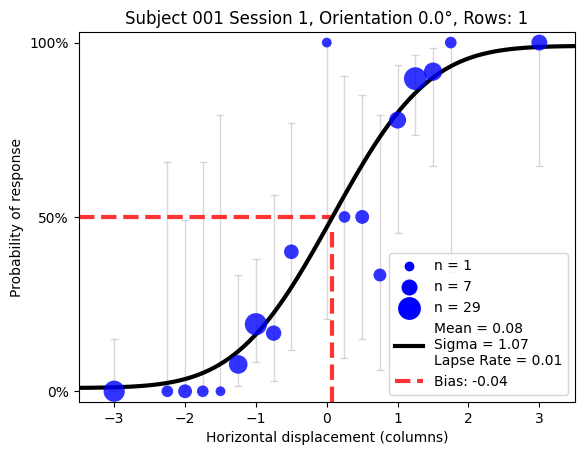

[-2.77555756e-15] [-1.11022302e-14]
Clipping to zero.


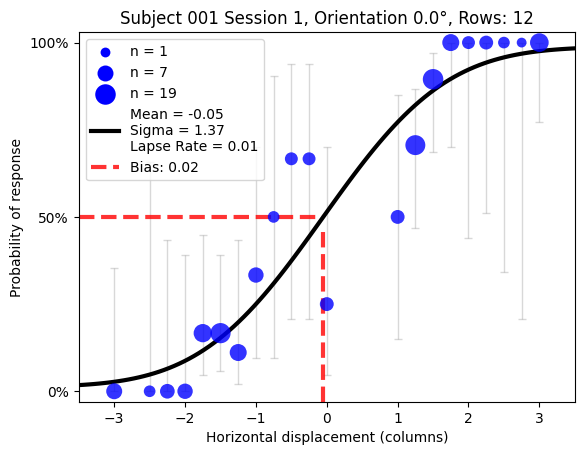

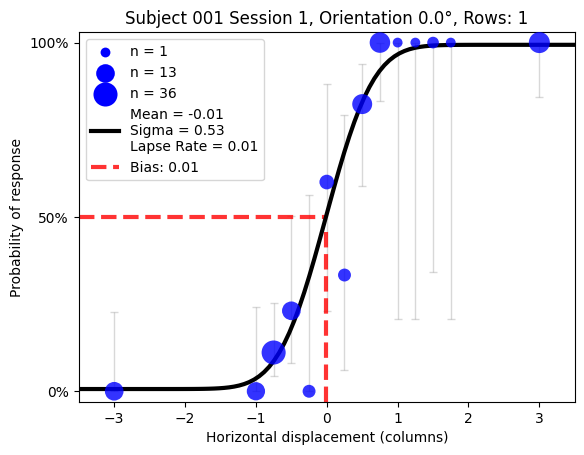

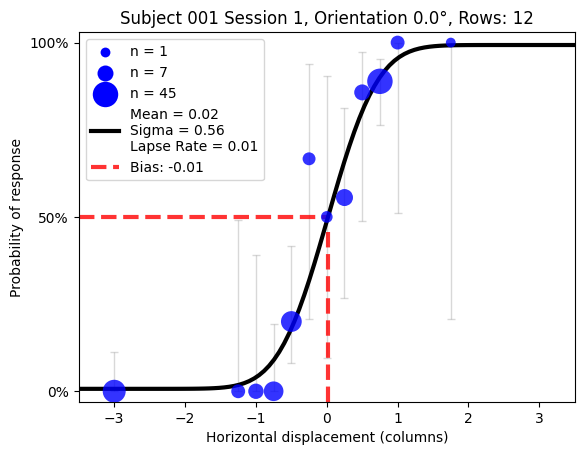

[-2.77555756e-15] []
Clipping to zero.


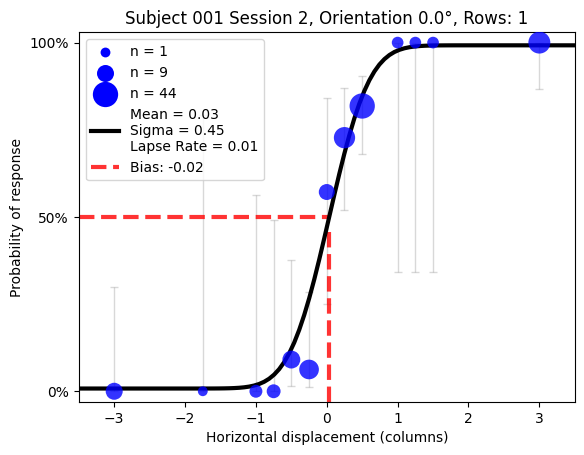

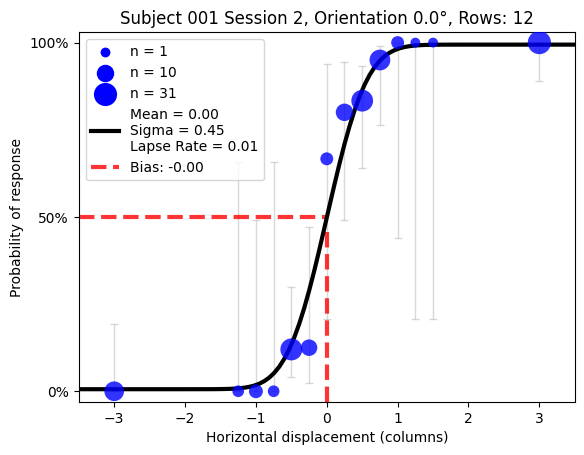

{np.float64(1.0): {'bias': [-0.04014397512482548, 0.005851284552831539, -0.01716658894778636], 'sensitivity': [0.932936266496239, 1.8936113057516963, 2.2446902226006458], 'orientation': []}, np.float64(12.0): {'bias': [0.02488994419800721, -0.008857170914609023, -0.0011385948202860493], 'sensitivity': [0.7302249808466156, 1.801302039464378, 2.2469553419582127], 'orientation': []}}


In [38]:
# TODO: put all of this into functions

size_scale = 50
results = {} # keys: n_rows, values: dict with keys 'biases' and 'orientations'

for session_id, session_df in data.items():
    # get test data only
    test_data = session_df[session_df['state'] == 'test']
    displacement = test_data['displacement_cols'].values
    choices = test_data['GetResponse.keys'].values
    orientation = test_data['orientation_degrees'].values
    session = test_data['session'].values
    n_row = test_data['n_row'].values
    
    # find and remove NaNs transperently, e.g. due to aborted session for the last trial
    nan_mask = pd.isna(displacement) | pd.isna(choices) | pd.isna(orientation) | pd.isna(session) | pd.isna(n_row)
    if np.sum(nan_mask) > 0:
        print("Warning: Removing", np.sum(nan_mask), "trials with NaN values")
        
        print("# of rows values:", n_row)
        print("Displacement values:", displacement)
        print("Choices:", choices)
        print("Orientation values:", orientation)
        print("Session values:", session)
        
        displacement = displacement[~nan_mask]
        choices = choices[~nan_mask]
        orientation = orientation[~nan_mask]
        session = session[~nan_mask]
        n_row = n_row[~nan_mask]
    
    # extract unique orientation and session number
    assert np.all(session == session[0]), "All session numbers in a session should be the same"
    session = session[0]
    
    # compute probability of right choice for each displacement 
    unique_n_row = np.unique(n_row)
    for n_r in unique_n_row:
        unique_orientation = np.unique(orientation % 90)  # ensure orientations are within [0, 90)
        for o in unique_orientation:
            if n_r not in results:
                results[n_r] = {'bias': [], 'sensitivity': [], 'orientation': []}
            
            orientation_n = orientation[(n_row == n_r) & (orientation % 90 == o)]
            choices_n = choices[(n_row == n_r) & (orientation % 90 == o)]
            displacement_n = displacement[(n_row == n_r) & (orientation % 90 == o)]
            unique_disp_n = np.sort(np.unique(displacement_n))
        
            probs = []
            cis_low, cis_up = [], []
            disp_selected = []
            data_points = []
            for disp in unique_disp_n:
                # for orientation == 0, upper right texture vertical -> positive displacement means upper texture more right
                # for orientation == 90, upper right texture horizontal -> positive displacement means upper texture more left
                disp_choices_right = choices_n[(displacement_n == disp) & (orientation_n == o)]
                disp_choices_left = choices_n[(displacement_n == -disp) & (orientation_n == (o + 90) % 180)]
                n = len(disp_choices_right) + len(disp_choices_left)
                if n == 0:
                    continue
                else:
                    k = np.sum(disp_choices_right == 'right') + np.sum(disp_choices_left == 'left')
                    p = k / n 
                    probs.append(p)
                    
                    ci_low, ci_upp = proportion_confint(count=k, nobs=n, method='wilson')
                    cis_low.append(ci_low)
                    cis_up.append(ci_upp)
                    disp_selected.append(disp)
                    data_points.append(n)
            probs = np.array(probs)
            cis_low = np.array(cis_low)
            cis_up = np.array(cis_up)
            data_points = np.array(data_points)
            
            # Psi fit results
            mu, sigma, lapse_rate = qp_results[session_id][f'n_row={int(n_r)}_orientation_degrees={int(o % 90)}']
            bias = - 1/2 * mu 
            sensitivity = 1 / sigma
            
            results[n_r]['bias'].append(bias)
            results[n_r]['sensitivity'].append(sensitivity)
            
            # plot the data and fit
            plt.figure()
            plt.title(f'Subject {subject_id} Session {session}, Orientation {o}°, Rows: {int(n_r)}')
            plt.xlim([min(unique_disp_n) - 0.05, max(unique_disp_n) + 0.05])
            plt.ylim([-0.05, 105])
            
            y_err_lower = (probs - cis_low) * 100
            y_err_upper = (cis_up - probs) * 100
            if np.any(y_err_lower < 0) or np.any(y_err_upper < 0):
                print("Warning: Negative error bars detected:")
                print(y_err_lower[y_err_lower < 0], y_err_upper[y_err_upper < 0])
                print("Clipping to zero.")
                y_err_lower = np.clip(y_err_lower, 0, None)
                y_err_upper = np.clip(y_err_upper, 0, None)
            if np.any(y_err_lower > 100) or np.any(y_err_upper > 100):
                print("Warning: Error bars greater than 100% detected:")
                print(y_err_lower[y_err_lower > 100], y_err_upper[y_err_upper > 100])
                print("Clipping to 100%.")
                y_err_lower = np.clip(y_err_lower, None, 100)
                y_err_upper = np.clip(y_err_upper, None, 100)
            plt.errorbar(disp_selected, probs * 100, yerr=[y_err_lower, y_err_upper], color='grey', fmt='none', linestyle='None', capsize=3, capthick=1, elinewidth=1, alpha=0.3, zorder=1)
            
            sizes = np.sqrt(data_points) * size_scale  # Scale sizes for better visibility
            plt.scatter(disp_selected, probs * 100, s=sizes, color='blue', alpha=0.8, zorder=3, linewidth=0)
            unique_data_points = np.unique(data_points)
            data_points_to_plot = [0, len(unique_data_points)//2, len(unique_data_points)-1] if len(unique_data_points) >= 3 else range(len(unique_data_points))
            for i, s in enumerate(unique_data_points): # legend for point sizes
                if i in data_points_to_plot:
                    plt.scatter([], [], s=np.sqrt(s) * size_scale, 
                            c='blue', linewidth=0, alpha=1.0, label=f'n = {s}')
            
            x_fit = np.linspace(-3.5, 3.5, 100)
            y_fit = cumulative_gaussian(x_fit, mu, sigma, lapse_rate)
            plt.plot(x_fit, y_fit * 100, label=f'Mean = {mu:.2f}\nSigma = {sigma:.2f}\nLapse Rate = {lapse_rate:.2f}', color='black', linewidth=3, zorder=2, alpha=1.0)
            plt.xlim(-3.5, 3.5)
            x_min, x_max = plt.xlim()
            y_min, y_max = plt.ylim()
            plt.axvline(mu, ymin = 0., ymax = (50 - y_min) / (y_max - y_min), color='red', linestyle='--', label=f'Bias: {bias:.2f}', linewidth=3, zorder=1, alpha = 0.8)
            plt.axhline(50, xmin= 0., xmax = (mu - x_min) / (x_max - x_min), color='red', linestyle='--', linewidth=3, zorder=1, alpha = 0.8)
            
            plt.xlabel('Horizontal displacement (columns)')
            plt.ylabel('Probability of response')
            
            plt.ylim([-3, 103])
            plt.yticks([0, 50, 100], ['0%', '50%', '100%'])

            plt.legend()
            plt.show()

print(results)

# TODO: put all of this into functions

results = {} # keys: n_rows, values: dict with keys 'biases' and 'orientations'

for session_id, session_df in data.items():
    # get test data only
    test_data = session_df[session_df['state'] == 'test']
    displacement = test_data['displacement_cols'].values
    choices = test_data['response'].values
    orientation = test_data['orientation_degrees'].values
    session = test_data['session'].values
    n_row = test_data['n_row'].values
    
    # find and remove NaNs transperently, e.g. due to aborted session for the last trial
    nan_mask = pd.isna(displacement) | pd.isna(choices) | pd.isna(orientation) | pd.isna(session) | pd.isna(n_row)
    if np.sum(nan_mask) > 0:
        print("Warning: Removing", np.sum(nan_mask), "trials with NaN values")
        
        print("# of rows values:", n_row)
        print("Displacement values:", displacement)
        print("Choices:", choices)
        print("Orientation values:", orientation)
        print("Session values:", session)
        
        displacement = displacement[~nan_mask]
        choices = choices[~nan_mask]
        orientation = orientation[~nan_mask]
        session = session[~nan_mask]
        n_row = n_row[~nan_mask]
    
    # extract unique orientation and session number
    assert np.all(session == session[0]), "All session numbers in a session should be the same"
    session = session[0]
    
    # compute probability of right choice for each displacement 
    unique_n_row = np.unique(n_row)
    for n in unique_n_row:
        unique_orientation = np.unique(orientation % 90)  # ensure orientations are within [0, 90)
        for o in unique_orientation:
            if n not in results:
                results[n] = {'bias': [], 'error': [], 'orientation': []}
            
            orientation_n = orientation[(n_row == n) & (orientation % 90 == o)]
            choices_n = choices[(n_row == n) & (orientation % 90 == o)]
            displacement_n = displacement[(n_row == n) & (orientation % 90 == o)]
            unique_disp_n = np.sort(np.unique(displacement_n))
        
            prob = []
            prob_sigma = []
            disp_selected = []
            for disp in unique_disp_n:
                # for orientation == 0, upper right texture vertical -> positive displacement means upper texture more right
                # for orientation == 90, upper right texture horizontal -> positive displacement means upper texture more left
                disp_choices_right = choices_n[(displacement_n == disp) & (orientation_n == o)]
                disp_choices_left = choices_n[(displacement_n == -disp) & (orientation_n == (o + 90) % 180)]
                if len(disp_choices_right) + len(disp_choices_left) == 0:
                    continue
                else:
                    f = (np.sum(disp_choices_right == 'right') + np.sum(disp_choices_left == 'left')) / (len(disp_choices_right) + len(disp_choices_left))
                    prob.append(f)
                        
                    f_sigma = np.sqrt(f * (1 - f) / (len(disp_choices_right) + len(disp_choices_left) + 1e-6)) # add small value to avoid zero error
                    prob_sigma.append(f_sigma)
                    disp_selected.append(disp)
            prob = np.array(prob)
            prob_sigma = np.array(prob_sigma)
            
            # fit cumulative Gaussian to get bias
            try:
                popt, pcov = curve_fit(cumulative_gaussian, disp_selected, prob, sigma=prob_sigma, absolute_sigma=True, p0=[0, 1, 0.01])
                mu, sigma, guess_rate = popt  # Extract fitted parameters
                
                # bias := towards texture oriented parallel to boundary
                bias = - 1/2 * mu  # Compute bias
                mu_err, sigma_err, guess_rate_err = np.sqrt(np.diag(pcov))
                bias_err = 1/2 * mu_err
                
                results[n]['bias'].append(bias)
                results[n]['error'].append(bias_err)
            except RuntimeError as e:
                print(f"Fit failed for session: {e}")
            
            # plot the data and fit
            plt.figure()
            plt.title(f'Subject {subject_id} Session {session}, Orientation {o}°, Rows: {int(n)}')
            plt.xlim([min(unique_disp_n) - 0.05, max(unique_disp_n) + 0.05])
            plt.ylim([-0.05, 105])
            
            plt.errorbar(disp_selected, prob * 100, yerr=prob_sigma * 100, label='Data', color='black', marker='o', linestyle='None', capsize=5)
            x_fit = np.linspace(-5, 5, 100)
            y_fit = cumulative_gaussian(x_fit, *popt)
            plt.plot(x_fit, y_fit * 100, label='Cumulative Gaussian Fit: \n' + f'   Mean = {mu:.2f} ± {mu_err:.2f}\n   Sigma = {sigma:.2f} ± {sigma_err:.2f}\n   Guess Rate = {guess_rate:.2f} ± {guess_rate_err:.2f}', color='blue')
            plt.xlim(-5, 5)
            x_min, x_max = plt.xlim()
            y_min, y_max = plt.ylim()
            plt.axvline(mu, ymin = 0., ymax = (50 - y_min) / (y_max - y_min), color='red', linestyle='--', label=f'Bias: {bias:.2f} ± {bias_err:.2f}', linewidth=2)
            plt.axhline(50, xmin= 0., xmax = (mu - x_min) / (x_max - x_min), color='red', linestyle='--', linewidth=2)
            
            plt.xlabel('Horizontal displacement of upper texture (columns)')
            plt.ylabel('Probability of upper boundary chosen to be "right"')
            
            # plt.ylim([-0.05, 105])
            # plt.yticks([0, 50, 100], ['0%', '50%', '100%'])

            plt.legend()
            plt.show()

print(results)

# 3. Plot Biases

C:\Users\kai.rothe\AppData\Local\Temp\ipykernel_3100\3164113742.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


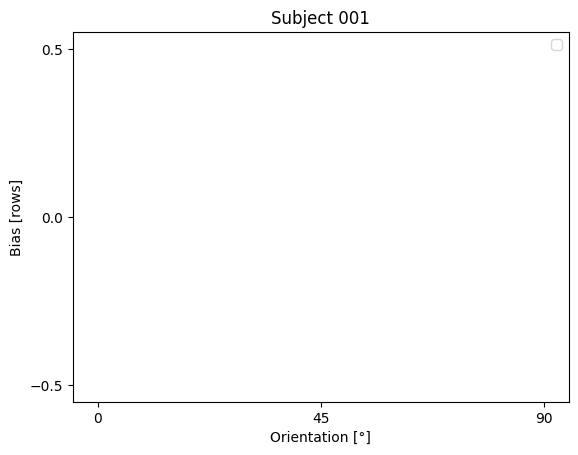

In [ ]:
fig = plt.figure()
plt.title(f'Subject {subject_id}')
plt.xlabel('Orientation [°]')
plt.ylabel('Bias [rows]')

# Define marker types for different n_rows
marker_types = {1: 's', 50: 'o'}  # Example: 'o' for n_rows=1, 's' for n_rows=12
labels = {1: 'row', 50: 'texture'}

for n_rows, res in results.items():
    orientations = res['orientation']
    biases = res['bias']
    errors = res['error']
    label = labels.get(n_rows, f'{n_rows} Rows')
    marker = marker_types.get(n_rows, 'x')  # Default to 'x' if n_rows not in marker_types
    
    if len(orientations) > 0:
        plt.errorbar(orientations, biases, yerr=errors, marker=marker, linestyle='-', label=label, capsize=5, markersize=7)

plt.ylim([-0.55, 0.55])
plt.yticks([-0.5, 0, 0.5])
plt.xlim([-5, 95])
plt.xticks([0, 45, 90])
plt.legend()
plt.show()

# 4. Save results

if save_results:
    savepath = os.path.join(save_directory, f"{subject_id}.png")
    fig.savefig(savepath)